# Note: this file using predefined models for simplicity

# CIFAR-10: Training and Testing on a Clean Dataset & Adversarial Analysis

## Imports and CIFAR-10 loading

In [1]:
# For loading model sanely
import os.path

# For plotting
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as DataUtils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tnrange, tqdm

import models.resnet as resnet

In [2]:
# Define the `device` PyTorch will be running on, please hope it is CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Notebook will use PyTorch Device: " + device.upper())

Notebook will use PyTorch Device: CUDA


In [3]:
DATA_ROOT = "./datasets/"



def get_CIFAR10_data_loaders(
    batchSize=128, trainSetSize=50000, validationSetSize=10000, testSetSize=10000
):

    # Create a separate transform for each dataset
    # (in case we decide to transform differently)
    trainSetTransform = transforms.Compose([transforms.ToTensor()])
    validationSetTransform = transforms.Compose([transforms.ToTensor()])
    testSetTransform = transforms.Compose([transforms.ToTensor()])

    # Download the dataset (note we technically use the same set for validation
    # and training)
    trainSet = datasets.CIFAR10(
        root=DATA_ROOT, download=True, train=True, transform=trainSetTransform
    )
    validationSet = datasets.CIFAR10(
        root=DATA_ROOT, download=True, train=True, transform=validationSetTransform
    )
    testSet = datasets.CIFAR10(
        root=DATA_ROOT, download=True, train=False, transform=testSetTransform
    )

    # Get the training indices to split into training and validation sets
    indices = np.arange(0, trainSetSize + validationSetSize)
    np.random.shuffle(indices)

    # Construct random samplers (for better training)
    trainSetSampler = SubsetRandomSampler(indices[:trainSetSize])
    validationSetSampler = SubsetRandomSampler(indices[trainSetSize:])
    testSetSampler = SubsetRandomSampler(np.arange(0, testSetSize))

    # Finally, construct the loaders that will be used to get images
    trainSetLoader = DataUtils.DataLoader(
        trainSet, batch_size=batchSize, sampler=trainSetSampler
    )
    validationSetLoader = DataUtils.DataLoader(
        validationSet, batch_size=batchSize, sampler=validationSetSampler
    )
    testSetLoader = DataUtils.DataLoader(
        testSet, batch_size=batchSize, sampler=testSetSampler
    )

    # Return the loaders
    return trainSetLoader, validationSetLoader, testSetLoader

## Training, Validation and Testing

In [4]:
# Get the data loaders (assume we do no validation)
trainSetLoader, _, testSetLoader = get_CIFAR10_data_loaders(
    trainSetSize=50000, validationSetSize=0
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# This method creates a new model and also trains it
def get_trained_model(load_if_available=False):
    # Helps adjust learning rate for better results
    def adjust_learning_rate(optimizer, epoch, learning_rate):
        actual_learning_rate = learning_rate
        if epoch >= 100:
            actual_learning_rate = 0.01
        if epoch >= 150:
            actual_learning_rate = 0.001
        for param_group in optimizer.param_groups:
            param_group["lr"] = actual_learning_rate

    # Various training parameters
    epochs = 200
    learning_rate = 0.1

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = resnet.ResNet50()
    model = model.to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002
    )

    # If a trained model already exists, give up the training part
    if load_if_available and os.path.isfile("./cifar10_model"):
        print("Found already trained model")

        model = torch.load("./cifar10_model")

        # Return the loaded model
        return model, loss_function, optimizer

    print("Training the model...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Training Progress"):
        # Adjust the learning rate
        adjust_learning_rate(optimizer, epoch, learning_rate)

        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)

            loss = loss_function(logits, labels)
            loss.backward()

            optimizer.step()

    print("... done!")

    # Return the trained model
    return model, loss_function, optimizer

In [6]:
# This method tests a given mode and prints the accuracy of that model
def test_trained_model(model):
    correct = 0

    print("Testing the model...")

    # Use a pretty progress bar to show updates
    for j, (images, labels) in enumerate(tqdm(testSetLoader, desc="Testing Progress")):
        # Cast to proper tensor
        images, labels = images.to(device), labels.to(device)

        # Predict
        logits = model(images)

        # The highest class represents the chosen class
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()

    print("... done! Accuracy: {}%".format(float(correct) * 100 / 10000))

## Putting it all together (the 'main')

In [7]:
model, loss_function, optimizer = get_trained_model(load_if_available=True)

test_trained_model(model)

Found already trained model
Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.91%


In [8]:
# Save the model
torch.save(model, "./cifar10_model")

In [9]:
# Load and test the loaded model (shortcutting many steps)
model = torch.load("./cifar10_model")

test_trained_model(model)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.68%


## Attacks and Their Results

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
# A possible attacks array (for nice printing):
attacks = {}

### Helper functions

In [12]:
def attack_model(model, loss_function, attack, **kwargs):
    # Network parameters
    loss_function = nn.CrossEntropyLoss()

    correct = 0

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    if epsilon is not None:
        print(
            "Testing the model under {} Attack using epsilon = {}, alpha = {}...".format(
                attack, epsilon, alpha
            )
        )
    else:
        print("Testing the model under {} Attack...".format(attack))

    # Get the attack
    attack_function = attacks[attack]

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Check if using a library attack
    if "library" in kwargs:
        from_library = kwargs["library"]
    else:
        from_library = False

    # Use a pretty progress bar to show updates
    for j, (images, labels) in enumerate(
        tqdm(testSetLoader, desc="{} Attack Testing Progress".format(attack))
    ):
        # Cast to proper tensor
        images, labels = images.to(device), labels.to(device)

        # Perturb the images using the attack
        if not from_library:
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
        else:
            perturbed_images = attack_function(images, labels)

        # Calculate results
        logits = model(perturbed_images)

        _, preds = torch.max(logits, 1)

        correct += (preds == labels).sum().item()

    print("... done! Accuracy: {}%\n\n".format(float(correct) * 100 / 10000))

In [13]:
def print_image(image, title, plot):
    numpy_image = image.numpy()
    plot.imshow(np.transpose(numpy_image, (1, 2, 0)))
    plot.set_title(title)

In [14]:
def print_attack(model, loss_function, attack, **kwargs):
    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Print 3 random images and the perturbed counterparts
    number_of_images = 3

    # This is becase for each image, we want to also print the perturbed image
    number_columns = 2

    # Subplot(r,c) provide the number of rows and columns
    figure, axarr = plt.subplots(
        number_of_images,
        number_columns,
        figsize=(2 * number_columns, 2.5 * number_of_images),
    )
    figure.subplots_adjust(hspace=1)

    # Check if using a library attack
    if "library" in kwargs:
        from_library = kwargs["library"]
    else:
        from_library = False

    if epsilon is not None:
        figure.suptitle("{} Attack using epsilon = {}".format(attack, epsilon))
    else:
        figure.suptitle("{} Attack".format(attack))

    # Get the attack
    attack_function = attacks[attack]

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Select the images and show the noise
    correct_image_broken = 0
    while True:
        # Get random image index
        index = np.random.randint(0, len(testSetLoader.dataset))

        # Get an image and cast it to CUDA if needed, cast to proper batches
        image, label = testSetLoader.dataset[index]
        image = image[None, :]
        label = torch.as_tensor((label,))

        image, label = image.to(device), label.to(device)

        # Predict
        logits = model(image)
        _, pred = torch.max(logits, 1)

        # Only count correct images
        if pred != label:
            continue

        # Perturb the images using the attack
        if not from_library:
            perturbed_image = attack_function(
                image,
                label,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
        else:
            perturbed_image = attack_function(image, label)

        # Calculate results
        logits = model(perturbed_image)
        _, fgsm_pred = torch.max(logits, 1)

        pred = pred.cpu().detach()[0]
        fgsm_pred = fgsm_pred.cpu().detach()[0]

        # Get the plots
        image_plot = axarr[correct_image_broken, 0]
        perturbed_image_plot = axarr[correct_image_broken, 1]

        # Print the original image
        print_image(
            torchvision.utils.make_grid(image.cpu().data, normalize=True),
            f"Predicted {testSetLoader.dataset.classes[pred]}",
            image_plot,
        )

        # Print the perturbed iamge
        print_image(
            torchvision.utils.make_grid(perturbed_image.cpu().data, normalize=True),
            f"Predicted {testSetLoader.dataset.classes[fgsm_pred]}",
            perturbed_image_plot,
        )

        # Only count correctly predicted images that got tricked
        correct_image_broken += 1
        if correct_image_broken >= number_of_images:
            break

### FGSM (Fast Sign Gradient Method) https://arxiv.org/abs/1412.6572

The formula that is used for producing the adversarial example in this case is:

$x' = x + \epsilon * sign(\nabla_{x}J(\theta, x, y))$, where J is the loss function used.

In [15]:
import attacks.fgsm as fgsm

attacks["FGSM"] = fgsm.fgsm_attack

In [16]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

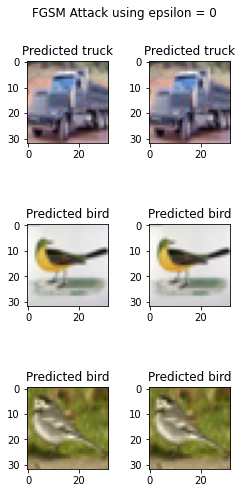

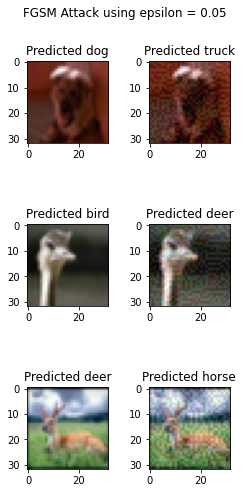

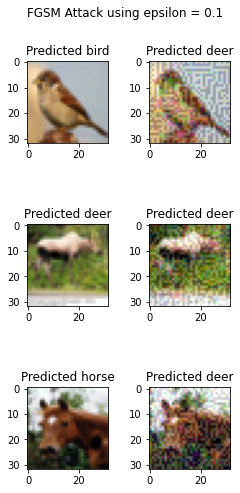

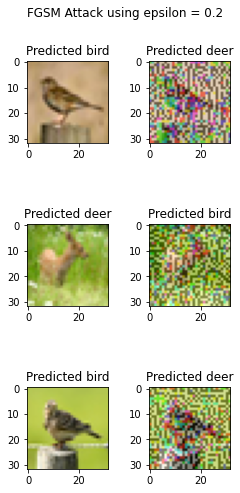

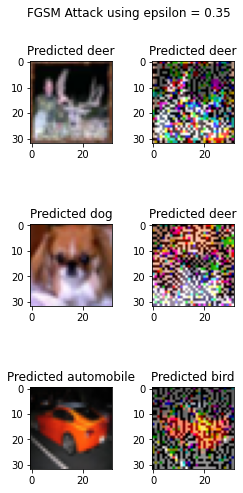

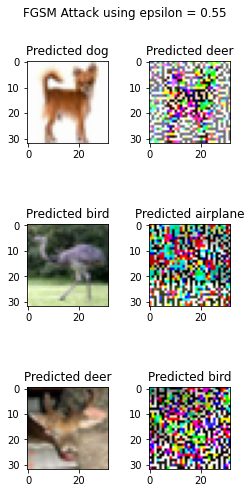

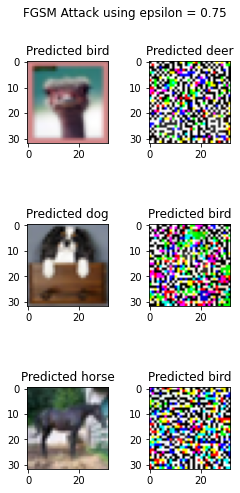

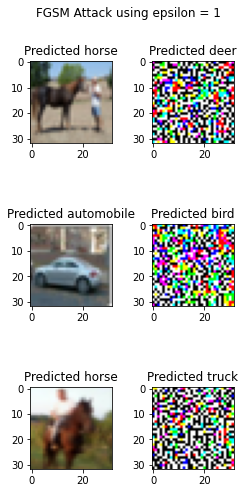

In [17]:
for epsilon in epsilons:
    print_attack(model, loss_function, "FGSM", epsilon=epsilon)

In [18]:
# Run test for each epsilon
for epsilon in epsilons:
    attack_model(model, loss_function, "FGSM", epsilon=epsilon)

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.55%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 41.08%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 34.49%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 24.66%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 17.42%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 12.46%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.84%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 9.76%




### I-FGSM / BIM (Iterative FGSM / Basic Iterative Method) https://arxiv.org/abs/1607.02533

The formula that is used for producing the adversarial example in this case is:

$x'_{0} = x$
$x'_{k + 1} = Clip_{x, \epsilon} \{x'_{k} + \alpha * sign(\nabla_{x}J(\theta, x'_{k}, y)\}$, where J is the loss function used. Note that in the paper proposing this method, $\alpha = 1$ is used, so pixels are changed by 1 in each iteration.

The formula for the clip function is also given in the paper.

In [19]:
import attacks.ifgsm as ifgsm

attacks["I-FGSM"] = ifgsm.ifgsm_attack

In [20]:
# Several values for epsilon. It's interesting to see how clamping affects results
epsilons = [0, 4 / 255, 0.05, 0.1]

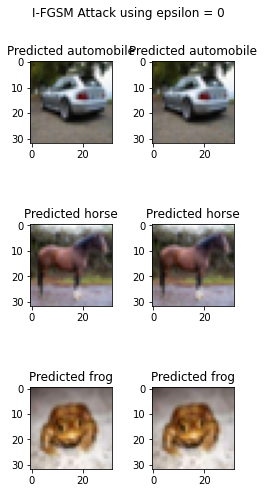

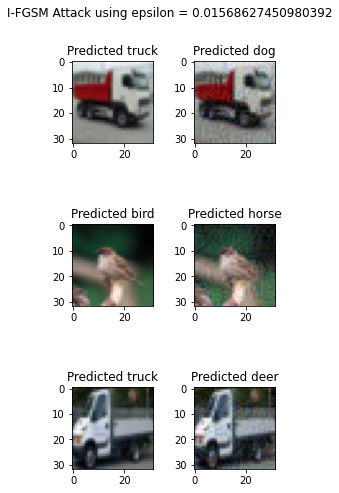

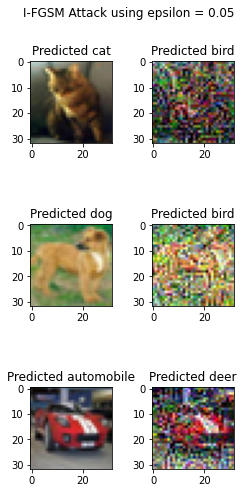

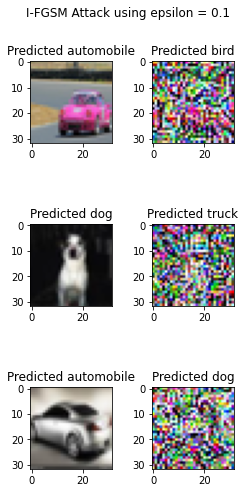

In [21]:
for epsilon in epsilons:
    print_attack(model, loss_function, "I-FGSM", epsilon=epsilon, alpha=1, iterations=0)

In [22]:
for epsilon in epsilons:
    attack_model(model, loss_function, "I-FGSM", epsilon=epsilon, alpha=1, iterations=0)

Testing the model under I-FGSM Attack using epsilon = 0, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.42%


Testing the model under I-FGSM Attack using epsilon = 0.01568627450980392, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.15%


Testing the model under I-FGSM Attack using epsilon = 0.05, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.1, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




### PGD (Projected Gradient Descent) https://arxiv.org/pdf/1706.06083.pdf

The formula that is used for producing the adversarial example in this case is:

$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$\n
where S is a set of allowed perturbations. Note that this is basically BIM with random initialisation. 

We use the $L_{\infty}$ norm here, i.e. we use clamping. 

In [23]:
import attacks.pgd as pgd

In [24]:
attacks["PGD"] = pgd.pgd_attack

In [25]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

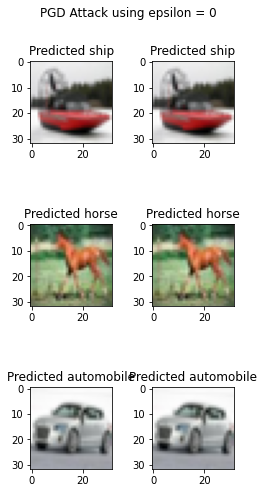

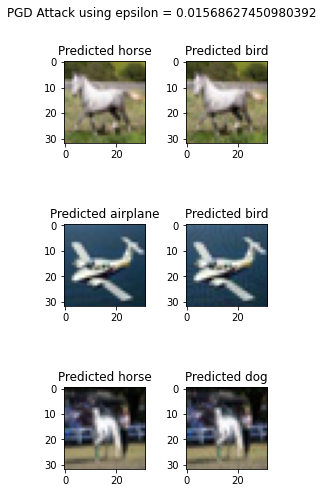

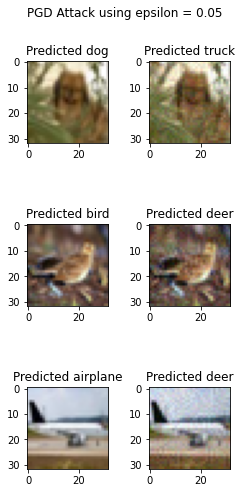

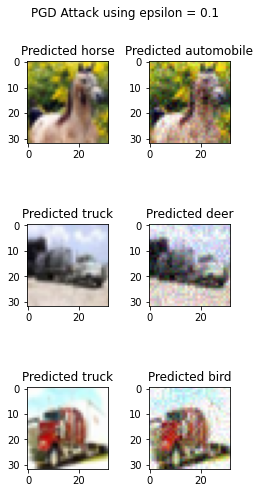

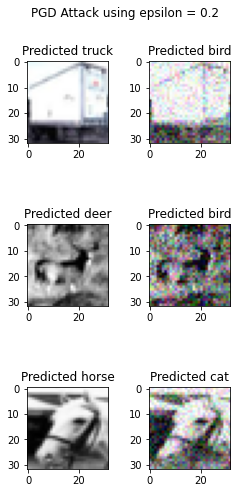

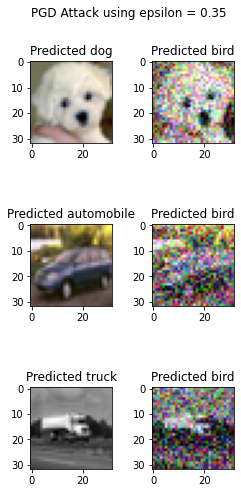

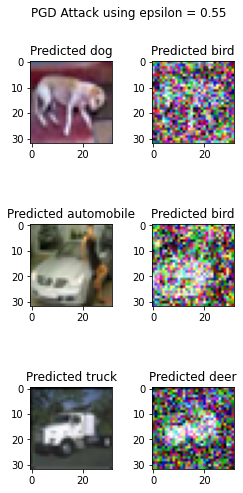

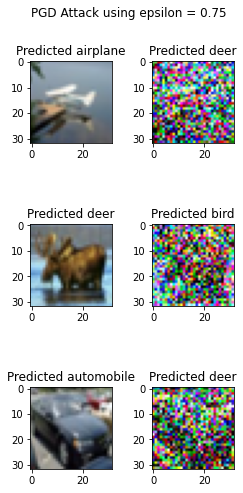

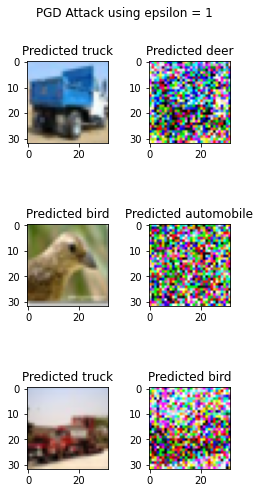

In [26]:
for epsilon in epsilons:
    print_attack(
        model, loss_function, "PGD", epsilon=epsilon, alpha=(2 / 255), iterations=20
    )

In [27]:
for epsilon in epsilons:
    attack_model(
        model, loss_function, "PGD", epsilon=epsilon, alpha=(2 / 255), iterations=20
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.72%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.51%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.02%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




## From here, use existing libraries to simplify usageimport torchattacks


In [28]:
import torchattacks

### CW-$L_{2}$ (Carlini & Wagner using $L_{2}$ norm) https://arxiv.org/pdf/1608.04644.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [29]:
cw_attack = torchattacks.CW(model, c=25)

attacks["CW"] = cw_attack

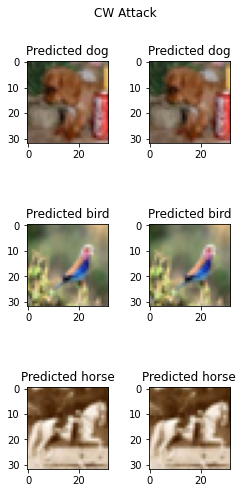

In [30]:
print_attack(model, loss_function, "CW", library=True)

In [31]:
attack_model(model, loss_function, "CW", epsilon=None, alpha=None, library=True)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 14.27%




## Adversarial Training

In [32]:
# Adversarial examples should be typically generated when model parameters are not
# changing i.e. model parameters are frozen. This step may not be required for very
# simple linear models, but is a must for models using components such as dropout
# or batch normalization.
def get_adversarially_trained_model(model, attack, **kwargs):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Run the attack
            model.eval()
            perturbed_image = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Predict and optimise
            logits = model(perturbed_image)

            loss = loss_function(logits, labels)
            loss.backward()

            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

### FGSM Adversarial Training

In [33]:
# Load and test the loaded model (shortcutting many steps)
model = torch.load("./cifar10_model")

test_trained_model(model)

Testing the model...


Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 87.53%


In [34]:
adversarial_model = get_adversarially_trained_model(model, "FGSM", epsilon=0.45)

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

... done!


In [35]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

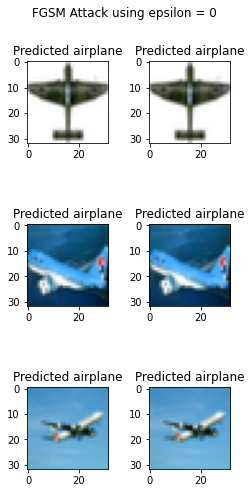

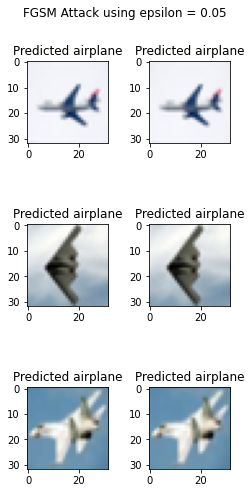

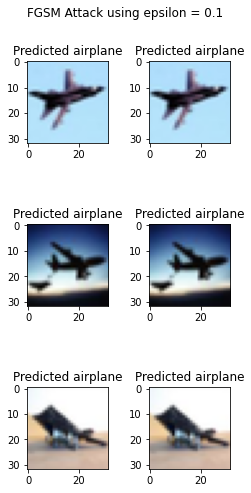

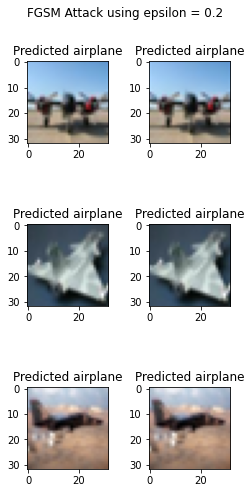

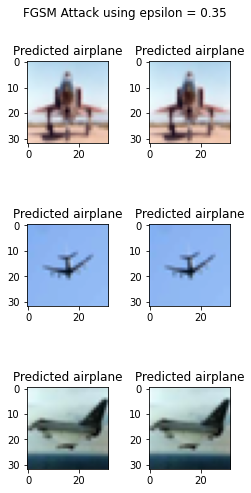

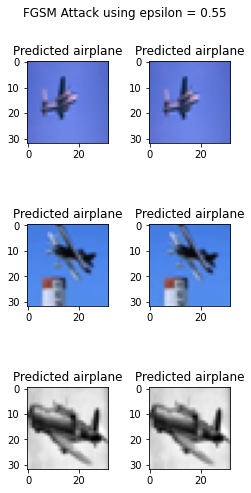

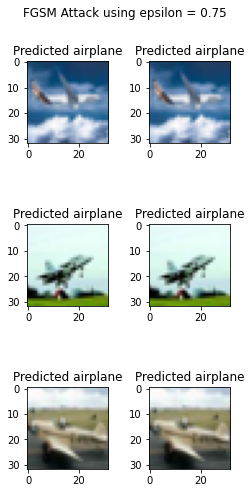

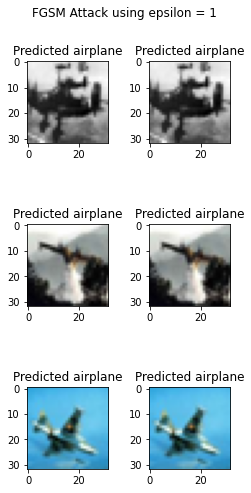

In [36]:
for epsilon in epsilons:
    print_attack(adversarial_model, loss_function, "FGSM", epsilon=epsilon)

In [37]:
for epsilon in epsilons:
    attack_model(adversarial_model, loss_function, "FGSM", epsilon=epsilon)

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

... done! Accuracy: 10.0%




In [38]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

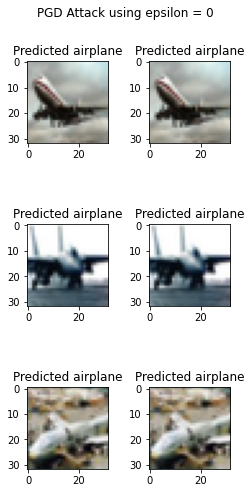

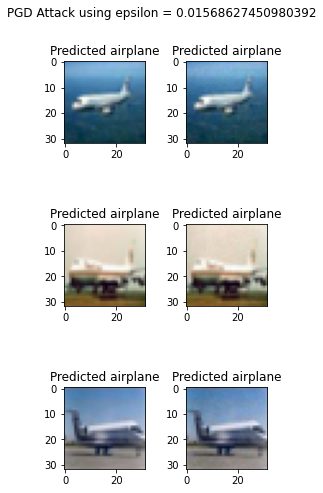

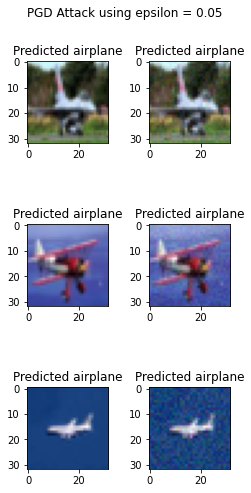

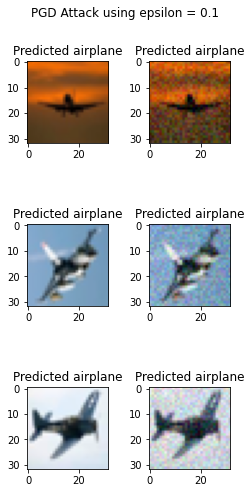

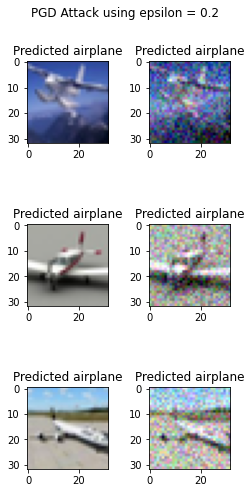

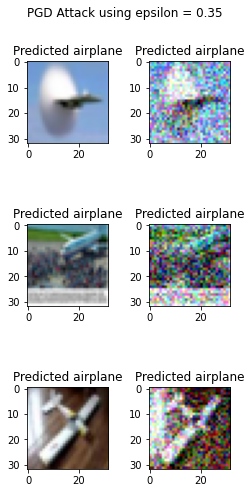

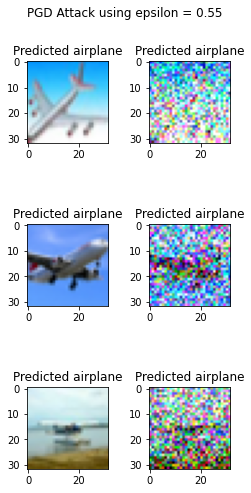

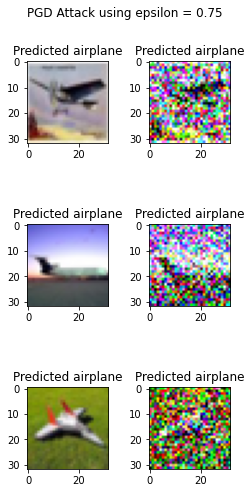

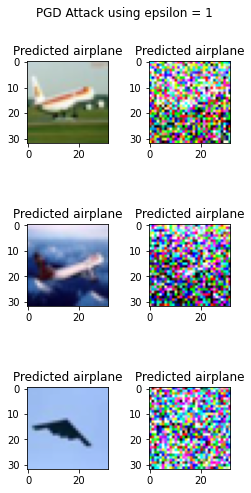

In [39]:
for epsilon in epsilons:
    print_attack(
        model, loss_function, "PGD", epsilon=epsilon, alpha=(2 / 255), iterations=20
    )

In [40]:
for epsilon in epsilons:
    attack_model(
        adversarial_model,
        loss_function,
        "PGD",
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/79 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 10.00 GiB total capacity; 5.06 GiB already allocated; 0 bytes free; 7.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
test_trained_model(model)

### PGD Adversarial Training

In [ ]:
# Load and test the loaded model (shortcutting many steps)
model = torch.load("./cifar10_model")

test_trained_model(model)

In [ ]:
adversarial_model = get_adversarially_trained_model(
    model, "PGD", epsilon=0.45, alpha=(2 / 255), iterations=20
)

In [ ]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [ ]:
for epsilon in epsilons:
    print_attack(adversarial_model, loss_function, "FGSM", epsilon=epsilon)

In [ ]:
for epsilon in epsilons:
    attack_model(adversarial_model, loss_function, "FGSM", epsilon=epsilon)

In [ ]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [ ]:
for epsilon in epsilons:
    print_attack(
        adversarial_model,
        loss_function,
        "PGD",
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

In [ ]:
for epsilon in epsilons:
    attack_model(
        adversarial_model,
        loss_function,
        "PGD",
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

In [ ]:
test_trained_model(model)